<a href="https://colab.research.google.com/github/Eschamp01/triton-kernels/blob/main/triton_vector_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Add Kernel: Triton vs native PyTorch

Here, I demonstrate a vector add Kernel written in Triton which outperforms PyTorch at larger matrix sizes, and matches PyTorch performance at smaller matrix sizes. The SoftMax operation is key in many deep neural networks, especially in Transformer-based models including Large Language Models and multi-modal models.

Tests were performed on an Nvidia Tesla T4 GPU.

In [1]:
!pip install torch -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 13.6 MB/s eta 0:00:00


In [2]:
!pip install triton -qq

In [3]:
# imports

import torch
import triton
from triton import cdiv
import triton.language as tl

In [4]:
print(torch.cuda.is_available()) # check that we have a CUDA compatible GPU, since this is where Triton works well
print(torch.cuda.get_device_name(0)) # check the GPU name. Original testing on Nvidia Tesla T4 GPU

True
Tesla T4


In [5]:
@triton.jit
def vector_add_kernel (a_ptr, b_ptr, out_ptr, num_elements: tl.constexpr, block_size: tl.constexpr):
  pid = tl.program_id(axis=0)
  block_start = pid * block_size
  thread_offsets = block_start + tl.arange(0, block_size)
  mask = thread_offsets < num_elements
  a_pointers = tl.load(a_ptr + thread_offsets, mask=mask)
  b_pointers = tl.load(b_ptr + thread_offsets, mask=mask)
  res = a_pointers + b_pointers
  tl.store(out_ptr + thread_offsets, res, mask=mask)

In [6]:
def ceil_div(x: int, y: int)-> int:
    return ((x+y-1)// y)

In [7]:
def vector_addition(a: torch.tensor, b: torch.tensor)-> torch.tensor:
    output_buffer = torch.empty_like(a)
    assert a.is_cuda and b.is_cuda
    num_elems = a.numel()
    assert num_elems == b.numel()

    block_size = 128
    grid_size = ceil_div(num_elems, block_size)
    grid = (grid_size,)
    # num_warps = 32
    k2 = vector_add_kernel[grid](a, b, output_buffer, num_elems, block_size)#, num_warps = num_warps)

    return output_buffer

In [8]:
def verify_numerics() -> bool:
    # verify numerical fidelity
    torch.manual_seed(2020)  # seed both cpu and gpu
    vec_size = 8192
    a = torch.rand(vec_size, device='cuda')
    b = torch.rand_like(a)
    torch_res = a + b
    triton_res = vector_addition(a, b)
    fidelity_correct = torch.allclose(torch_res, triton_res)
    print(f"{fidelity_correct=}") # neat Python syntax I didn't know about

fidelity_correct=True


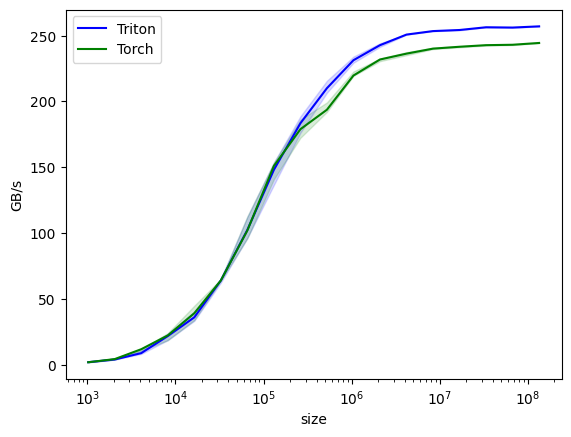

vector-add-performance:
           size      Triton       Torch
0        1024.0    1.959184    1.920000
1        2048.0    4.000000    4.302521
2        4096.0    8.853026   11.815385
3        8192.0   21.787235   22.260869
4       16384.0   36.035190   39.133757
5       32768.0   63.999998   63.999998
6       65536.0  102.400003  101.975103
7      131072.0  148.048195  151.004606
8      262144.0  183.402983  178.897181
9      524288.0  210.051276  193.702454
10    1048576.0  231.303526  219.673742
11    2097152.0  242.725927  231.849058
12    4194304.0  250.775518  236.307695
13    8388608.0  253.432273  240.104424
14   16777216.0  254.256749  241.533161
15   33554432.0  256.333761  242.737631
16   67108864.0  256.106808  243.044742
17  134217728.0  257.026234  244.411447


<Figure size 640x480 with 0 Axes>

In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2 ** i for i in range(10, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name.
        args={}  # Values for function arguments not in `x_names` and `y_names`.
    )
)

def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: vector_addition(x, y), quantiles=quantiles)
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

if __name__ == '__main__':
    verify_numerics()
    benchmark.run(print_data=True, show_plots=True, save_path='./vec_add_perf')
